### IMPORT PACKAGES

In [2]:
# Basic Data Processing Packages
from IPython.display import Image, display, HTML
import pandas as pd
import numpy as np
import re

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import base64
from io import BytesIO

# Sklearn Packages
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.spatial.distance import euclidean
from sklearn.feature_extraction import text
from sklearn.cluster import KMeans
from sklearn.base import clone
from sklearn.metrics import (calinski_harabasz_score,
                             davies_bouldin_score,
                             silhouette_score)

import warnings
warnings.filterwarnings('ignore', module='seaborn')

# Web Interaction and Display
HTML(
    """
<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/
jquery.min.js "></script>
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
 } else {
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit"
    value="Click here to toggle on/off the raw code."></form>
"""
)

### DEFINE FUNCTIONS

In [3]:
def create_vector(dataframe, stop_words, min_df=0.05, max_df=None):
    """Vectorize the dataframe using TfidfVectorizer

    Parameters
    ----------
    dataframe: pandas.DataFrame
        Dataframe that contains Review_Text column for vectorization
    stop_words: list
        List that contains strings not to be included in the vectorization
    min_df: float
        Minimum document frequency for a word to be included
    max_df: float
        Maximum document frequency for a word to be included

    Returns
    -------
    vectorizer: TfidfVectorizer
        TfidfVectorizer used on the text data
    X: sparse matrix
        Matrix that contains the vectorized text data
    """
    vectorizer = TfidfVectorizer(min_df=0.05,
                                 token_pattern=r"\b[a-zA-Z'-]+\b",
                                 stop_words=stop_words)
    X = vectorizer.fit_transform(dataframe['Review_Text'])
    return vectorizer, X


def get_top_words_hierarchical(X, vectorizer, predictions):
    """
    Identify and return the top words for each cluster in hierarchical
    clustering.

    Parameters
    ----------
    X : ndarray or sparse matrix
        The feature matrix obtained from TF-IDF vectorization, converted to
        a dense ndarray if it was a sparse matrix.
    vectorizer : TfidfVectorizer
        The vectorizer that was used to transform raw text data into the
        feature matrix X.
    predictions: ndarray
        The cluster labels for each instance in X obtained from
        hierarchical clustering, as a NumPy array.

    Returns
    -------
    top_words : pandas.DataFrame
        A DataFrame where each column corresponds to a cluster (1 to n) 
        and contains the top 10 words that have the highest mean TF-IDF
        score in that cluster.
    """

    terms = vectorizer.get_feature_names_out()
    df_disney = pd.DataFrame(X, columns=terms)
    df_disney['Cluster'] = predictions
    n = len(set(predictions))
    top_words = pd.DataFrame()

    for cluster in range(1, n+1):
        df1 = df_disney[df_disney['Cluster'] == cluster].iloc[:, :-1]
        top_words[cluster] = df1.mean().sort_values(ascending=False).index[:10]

    return top_words


def plot1(Z):
    """
    Generate a dendrogram plot from hierarchical clustering data.

    Parameters
    ----------
    Z : array_like
        The hierarchical clustering encoded as a linkage matrix.

    Returns
    -------
    Figure
        A matplotlib Figure object containing the dendrogram plot.
    """
    fig, ax = plt.subplots()
    dendrogram(Z, truncate_mode='level', p=5, ax=ax)
    ax.set_ylabel(r"$\Delta$")
    return fig


def get_top_words(vectorizer, kmeans):
    """Return a DataFrame that contains the top words of each cluster

    Parameters
    ----------
    vectorizer: TfidfVectorizer
        Vectorizer class used in transforming the bag of words
    kmeans: KMeans
        Kmeans clustering class used in clustering the dataset

    Returns
    -------
    top_words: pandas.DataFrame
        Contains top words per cluster
    """
    top_words = pd.DataFrame()
    terms = vectorizer.get_feature_names_out()
    n_clusters = kmeans.cluster_centers_.shape[0]
    for n in range(n_clusters):
        center = kmeans.cluster_centers_[n]
        sorted_idx = np.argsort(center)[::-1][:10]
        top_terms = [terms[idx] for idx in sorted_idx]
        top_words['Cluster_' + str(n+1)] = top_terms
    return top_words


def kmeans_clustering(X, n_cluster=10):
    """Perform KMeans clusterin on the dataset

    Parameters
    ----------
    X: array-like
        Contains the data to be clustered
    n_cluster: int
        The number of clusters to be used in KMeans

    Returns
    -------
    clusterer: KMeans
        KMeans clusterer object used in clustering
    prediction: numpy.array
        Array that contains cluster labels for the dataset
    """
    kmeans = KMeans(n_clusters=n_cluster, random_state=69, n_init="auto")
    predictions = kmeans.fit_predict(X)
    return kmeans, predictions

# LOAD THE DATA

In [9]:
# Import the Dataset
df = pd.read_csv(
    "/mnt/data/public/disneyland-reviews/DisneylandReviews.csv",
    encoding="ISO-8859-1"
)

In [10]:
df.dtypes

Review_ID             int64
Rating                int64
Year_Month           object
Reviewer_Location    object
Review_Text          object
Branch               object
dtype: object

In [11]:
# Split the Data
df_pos = df[(df.Rating == 4) | (df.Rating == 5)].copy()
df_neg = df[(df.Rating == 1) | (df.Rating == 2) | (df.Rating == 3)].copy()

In [12]:
addl_stop_words = {'hongkong','hong','kong','paris','california','disney',
                   'disneyland','florida','hk',"it's",'t','s'}
stop_words = list(text.ENGLISH_STOP_WORDS.union(addl_stop_words))
vectorizer_pos, X_pos = create_vector(df_pos, stop_words, min_df=0.05)

In [13]:
addl_stop_words = {'hongkong','hong','kong','paris','california','disney',
                   'disneyland','florida','hk',"it's",'t','s', 'day', 'good',
                   'fun', 'great', 'like', 'love', 'visit', 'kids',
                   'children', 'adults', 'really', 'just', 'park', 'parks',
                   'ride', 'rides'}
stop_words = list(text.ENGLISH_STOP_WORDS.union(addl_stop_words))
vectorizer_neg, X_neg = create_vector(df_neg, stop_words, min_df=0.05)

# HEIRARCHICAL

## COMPLETE LINKAGE ON NEGATIVE REVIEWS

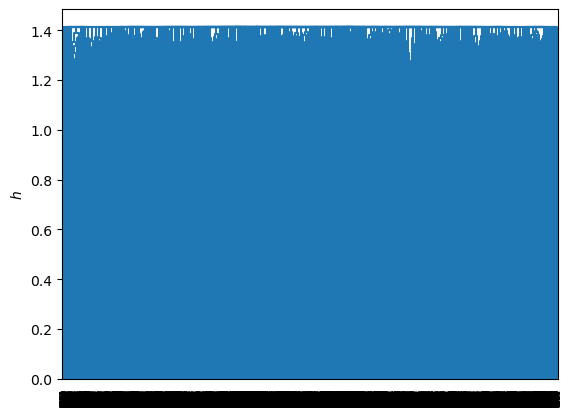

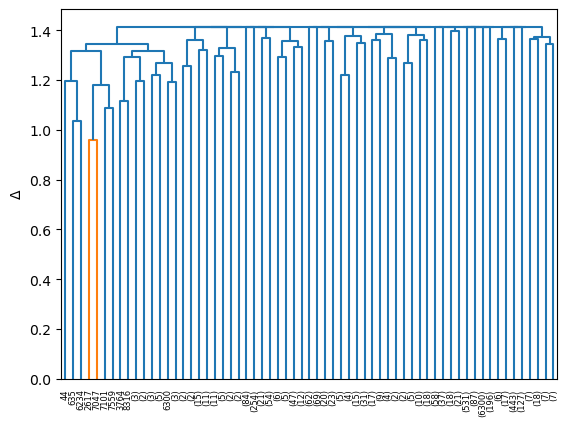

In [28]:
Z = linkage(X_neg.toarray(), method="complete", optimal_ordering=True)
fig, ax = plt.subplots()
dn = dendrogram(Z, ax=ax)
ax.set_ylabel(r"$h$");
plot1(Z);

For the complete linkage clustering, we can observe that the uniformity in the height of the first linkage of most clusters (the very short vertical lines at the bottom of the dendrogram) indicates that within individual clusters, the words are quite similar.

In [15]:
agg_complete = AgglomerativeClustering(n_clusters=10, linkage="complete")
predictions_complete = agg_complete.fit_predict(X_neg.toarray())

In [16]:
get_top_words_hierarchical(
    X_neg.toarray(),
    vectorizer_neg,
    predictions_complete)

,1,2,3,4,5,6,7,8,9,10
0,attractions,happy,cast,year,small,hotel,time,land,mountain,able
1,closed,pay,members,old,years,stayed,french,crowded,space,actually
2,hours,time,time,prices,ago,food,food,time,went,adventure
3,hour,close,rude,food,time,open,disappointing,theme,thunder,ago
4,looking,food,people,time,week,time,staff,way,time,area
5,time,staff,pass,bad,compared,went,small,bit,big,areas
6,went,place,fast,long,place,hours,don't,people,closed,arrived
7,staff,didn't,told,people,hot,staff,parade,half,days,attraction
8,huge,need,staff,fast,world,early,better,place,having,attractions
9,people,service,line,closed,ones,queues,expensive,food,times,away


## WARD'S LINKAGE FOR NEGATIVE REVIEWS

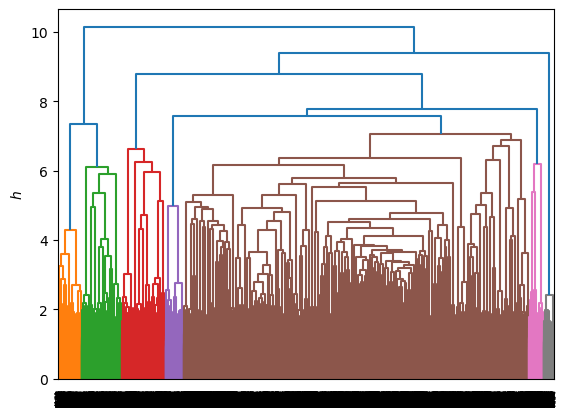

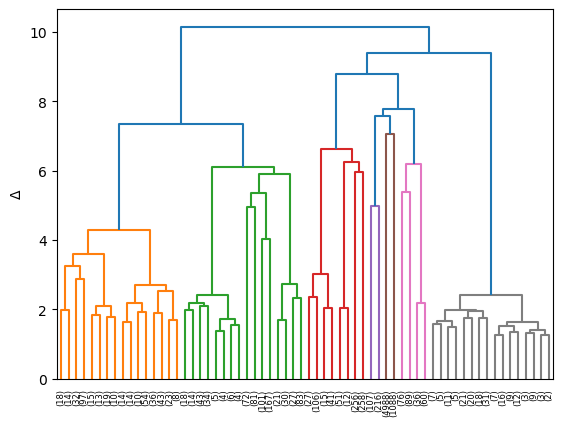

In [29]:
Z = linkage(dense_X_neg, method="ward", optimal_ordering=True)
fig, ax = plt.subplots()
dn = dendrogram(Z, ax=ax)
ax.set_ylabel(r"$h$");
plot1(Z);

For the ward clustering dendrogram for Disneyland's negative reviews indicates a hierarchical structure where clusters are merged based on minimizing the variance within clusters. It shows a range of cluster sizes, with several large clusters (indicated by long vertical lines) and numerous smaller clusters. This method tends to create more compact clusters compared to complete linkage.

In [17]:
agg = AgglomerativeClustering(n_clusters=10, linkage="ward")
predictions = agg.fit_predict(X_neg.toarray())

The DataFrame indicates the top words for each cluster obtained from a complete linkage hierarchical clustering of the dataset. Each column represents a cluster (from 1 to 10), and each row contains the top terms that are top words of the reviews within that cluster, based on the mean TF-IDF value of the terms.

In [19]:
get_top_words_hierarchical(X_neg.toarray(), vectorizer_neg, predictions)

,1,2,3,4,5,6,7,8,9,10
0,time,queue,food,orlando,cast,fast,line,staff,tickets,able
1,people,queues,hotel,world,members,pass,lines,rude,ticket,actually
2,place,time,expensive,compared,rude,passes,wait,french,buy,adventure
3,food,long,service,small,time,time,minutes,people,price,ago
4,went,hour,prices,experience,magic,wait,long,time,time,area
5,staff,people,staff,went,don't,use,time,queue,line,areas
6,small,minutes,time,better,times,got,crowded,food,food,arrived
7,experience,food,poor,visited,people,hours,people,told,expensive,attraction
8,long,characters,overpriced,disappointed,world,long,crowds,experience,got,attractions
9,did,hours,water,time,service,line,waiting,don't,long,away


# OPTICS

## POSITIVE REVIEWS

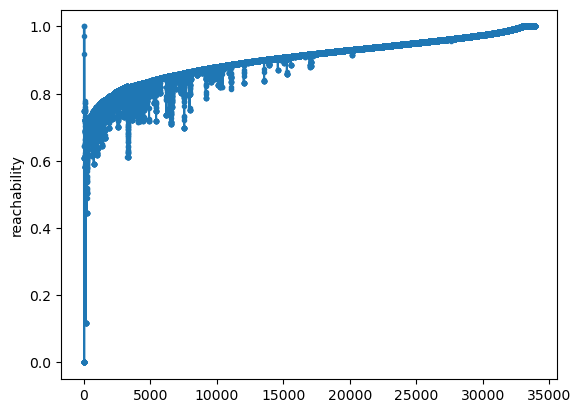

In [84]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan

optics = OPTICS(min_samples=10, cluster_method="dbscan")
dense_X_pos = X_pos.toarray()
optics.fit(dense_X_pos)
plt.plot(optics.reachability_[optics.ordering_], ".-")
plt.ylabel("reachability")
plt.show()


# NEGATIVE REVIEWS

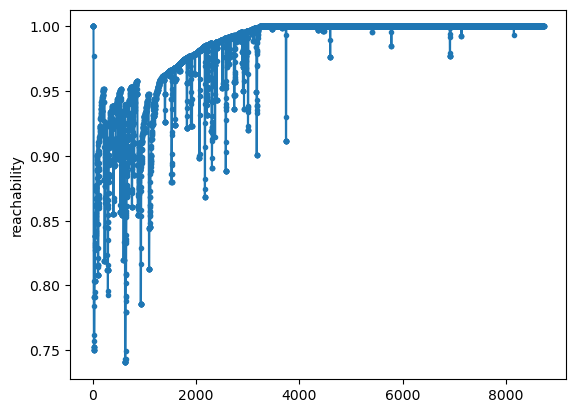

In [85]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan

optics = OPTICS(min_samples=10, cluster_method="dbscan")
dense_X_neg = X_neg.toarray()
optics.fit(dense_X_neg)
plt.plot(optics.reachability_[optics.ordering_], ".-")
plt.ylabel("reachability")
plt.show()

# DIMENSIONALITY REDUCTION + KMEANS

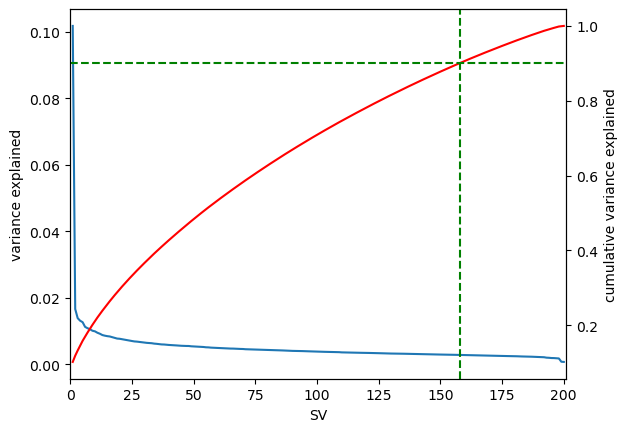

In [20]:
svd = TruncatedSVD(n_components=X_neg.shape[1])
svd.fit(X_neg)
sigma = svd.singular_values_
nssd = np.square(sigma)/(np.square(sigma).sum())
fig, ax = plt.subplots()
ax.plot(range(1, len(nssd)+1), nssd, '-', label='individual')
ax.set_xlim(0, len(nssd)+1)
ax.set_xlabel('SV')
ax.set_ylabel('variance explained')
ax = ax.twinx()
ax.plot(range(1, len(nssd)+1), nssd.cumsum(), 'r-', label='cumulative')
ax.axhline(0.9, ls='--', color='g')
ax.axvline(158, ls='--', color='g')
ax.set_ylabel('cumulative variance explained');

In [21]:
kmeans, predict = kmeans_clustering(X_neg, n_cluster=10)

In [22]:
df_neg['Cluster'] = predict

In [23]:
get_top_words(vectorizer_neg, kmeans)

,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10
0,place,crowds,queues,time,staff,small,line,cast,lines,closed
1,people,people,long,queue,rude,world,pass,members,long,attractions
2,food,time,food,hotel,people,time,fast,world,time,mountain
3,time,lines,queue,food,friendly,food,wait,time,people,open
4,expensive,went,time,old,food,better,time,people,food,time
5,crowded,times,expensive,people,time,attractions,minutes,rude,attractions,disappointed
6,don't,crowded,people,year,experience,experience,people,magic,crowded,thunder
7,enjoy,wait,attractions,characters,service,expensive,waiting,times,line,food
8,money,long,hour,went,french,orlando,hours,line,wait,visited
9,experience,don't,minutes,did,magic,worth,hour,don't,waiting,went


# SUMMARY

- HEIRARCHICAL
    - COMPLETE : Clusters are relatively the same for negative reviews KMeans, but with significantly longer runtime.
    - WARD : Clusters are relatively the same for negative reviews KMeans, but with significantly longer runtime.
    - Both methods fail to execute for the positive reviews dataset due to its size.
<br><br>
- OPTICS
    - Run time is decent for both Positive and Negative Reviews
    - The reachability plot does not show efficient clustering, the valleys are not evident in the plot.
    - Not the best clustering method for Noisy Data like Bag of Words.
<br><br>
- SVD KMeans
    - Reveals No Direct Improvement with Results and Run Time.